In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import os

In [2]:
def log_results(results, filename, type_):
    # Define the headers for your CSV file

    if type_ == '1k_logs':
        headers = ['Mean episodic reward', 'Critic loss', 'Actor loss']  # Add your result names here

        # Open the CSV file in 'append' mode so that existing data isn't overwritten
        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            
            # Write headers if the file is empty
            if csvfile.tell() == 0:
                writer.writerow(headers)
            
            # Write the results to the CSV file
            writer.writerow(results)

    elif type_ == '20k_ep_rewards':
        headers = ['Mean episodic reward']  # Add your result names here

        # Open the CSV file in 'append' mode so that existing data isn't overwritten
        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            
            # Write headers if the file is empty
            if csvfile.tell() == 0:
                writer.writerow(headers)
            
            # Write the results to the CSV file
            writer.writerow(results)


In [19]:
#IF ON COLAB
############àSEARCH HOW TO SET ON COLAB PYTHON 3.5, IF NOT IT DOES NOT WORK
!pip install gymnasium "gymnasium[classic-control,mujoco]==0.29.1"

^C
Traceback (most recent call last):
  File "/Users/thomasbrunet/opt/anaconda3/envs/rl_project/bin/pip", line 10, in <module>
    sys.exit(main())
  File "/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/pip/_internal/cli/main.py", line 77, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
  File "/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
  File "/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1030, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 

In [ ]:
#CPU set-up with GPU available: run this:
device=torch.device("cpu")
print(device)

cpu


In [ ]:
#Else:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))
print(device)

In [3]:
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()

        self.model = nn.Sequential(
            
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,n_actions),
            nn.Softmax()
        )

    def forward(self,x):
        x = torch.Tensor(x)
        return self.model(x)

In [4]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)
        )

    def forward(self,x):
        x = torch.Tensor(x)
        return self.model(x)

In [5]:
class A2C_Agent(): #this should work with more parallel environment already, not the evaluate functions

    def __init__(self, n_envs, actor, critic, lr_actor, lr_critic):
        self.n_envs = n_envs
        self.actor = actor
        self.critic = critic
        self.actor_optimizer = torch.optim.Adam(actor.parameters(), lr=lr_actor)
        self.critic_optimizer = torch.optim.Adam(critic.parameters(), lr=lr_critic)
    

    def choose_action(self, states, action_type = "training"):        
        state_values = self.critic.forward(states)
        action_probs = self.actor.forward(states)
        

        if action_type == "training":
            actions_pd = torch.distributions.Categorical(probs=action_probs)
            actions = actions_pd.sample()
            actions_log_prog = actions_pd.log_prob(actions)
            return actions, actions_log_prog, state_values
        
        elif action_type == "greedy":
            actions = torch.argmax(action_probs) #greedy policy
            return actions, state_values
    
    def get_losses(self, rewards, states, next_states, log_prob, gamma, terminated):
        
        delta = torch.Tensor(rewards.reshape(self.n_envs,1)) + (1-torch.Tensor(terminated.reshape(self.n_envs,1))) * gamma * self.critic(next_states).detach()
        advantage = delta - self.critic(states)        

        critic_loss = advantage.pow(2).mean()
        
        actor_loss = - (advantage.detach() * log_prob.reshape_as(advantage.detach())).mean()

        # delta = torch.Tensor(rewards) + (1-torch.Tensor(terminated)) * gamma * self.critic(next_states)
        # advantage = delta - self.critic(states)    

        # critic_loss = advantage.pow(2)

        # actor_loss = - (advantage.detach() * log_prob.reshape_as(advantage.detach()))



        return actor_loss, critic_loss
    
    def update_params(self, critic_loss, actor_loss):
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

    def evaluate_performance(self):
        
        episodic_rewards_10 = []
        v_values = []
        # env = gym.vector.AsyncVectorEnv( [lambda:gym.make("CartPole-v1") for i in range(1)])
        env = gym.make("CartPole-v1")
        for j in range(10):
            state, _ = env.reset()
            total_reward = 0
            done = False
            while not done:
                action, state_values = self.choose_action(state, action_type= "greedy")
                #get the current value function fro one trajectory (j==0)
                if j ==0 : v_values.append( state_values.detach().data.numpy() ) #shitty with float
                
                #go to the next state
                next_state, reward, terminated, truncated, _  = env.step(action.detach().data.numpy())
                total_reward += reward
                state = next_state
                
                done = terminated or truncated
            episodic_rewards_10.append(total_reward)
        print("episodic return of the 20000:", np.mean(episodic_rewards_10))
        return np.mean(episodic_rewards_10), v_values
        #comment this if you are trying with more envs
        #plt.plot(v_values)
        #plt.xlabel("trajectory")
        #plt.xlabel("V lalue")
        #plt.title("V values for the first evaluation trajectory")
        #plt.savefig(f'figures/v_values_{total_steps}.png')
        #plt.close()
        print("\n")
    
    def evaluate_training(self, episode_rewards, actor_loss, critic_loss, filename, type_):
        # print("current episodic return:", np.mean(episode_rewards))
        # print("critic loss:", (critic_loss.detach().data.numpy()))
        # print("actor loss:", (actor_loss.detach().data.numpy()))
        log_results([np.mean(episode_rewards), critic_loss.detach().data.numpy(), actor_loss.detach().data.numpy()], filename, type_)
        # print("\n")
    


In [6]:
def train(seed, filenames, n_envs=1, n_steps=1, sparse=False):
    episode_rewards = []
    v_values = []
    total_steps = 0
    max_steps = 500000

    env = gym.vector.AsyncVectorEnv([lambda:gym.make("CartPole-v1") for i in range(n_envs)])
    state_dim  = env.single_observation_space.shape[0]
    n_actions = env.single_action_space.n

    torch.manual_seed(seed)
    actor = Actor(state_dim, n_actions)
    critic = Critic(state_dim)
    agent = A2C_Agent(n_envs=1, actor= actor, critic= critic, lr_actor=1e-5, lr_critic=1e-3)
    
    state = env.reset(seed=seed)[0]

    while total_steps < max_steps:  

        terminated = False
        ep_reward = 0
        ## We don't need to reset the environment since we use AsyncEnv ##
        
        while not terminated:
            actions, actions_log_prog, _ = agent.choose_action(state)
            
            next_state, reward, terminated, truncated, _ = env.step(actions.numpy())

            if sparse:
                if random.random() < 0.9:
                    reward = np.array([0.])
            
            actor_loss, critic_loss = agent.get_losses(reward, state, next_state, actions_log_prog, 0.99, terminated)
            ep_reward += reward
            state = next_state

            agent.update_params(critic_loss, actor_loss)

            if (total_steps % 1000) == 0: 
                agent.evaluate_training(episode_rewards, actor_loss, critic_loss, filenames[0], "1k_logs")
                episode_rewards = []
            if (total_steps % 20000 == 0): 
                reward_20k, vs = agent.evaluate_performance()
                log_results([reward_20k], filenames[1], "20k_ep_rewards")
                v_values.append(vs)


            terminated = terminated or truncated

            if total_steps >= max_steps:
                break  
            else: total_steps += 1
            
                
        episode_rewards.append(ep_reward)
        
    return v_values
        

In [7]:
folder_name = 'results_31'
if not os.path.exists(folder_name): os.makedirs(folder_name)

seed = 3112
filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv')]

vs = train(seed, filenames)

/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


episodic return of the 20000: 10.0
episodic return of the 20000: 260.9
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 441.6
episodic return of the 20000: 471.9
episodic return of the 20000: 451.2
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0


<Axes: xlabel='None', ylabel='Critic loss'>

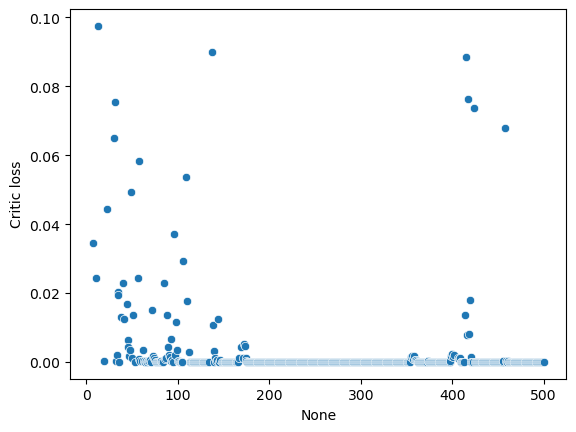

In [8]:
import pandas as pd
import seaborn as sns

data = pd.read_csv(filenames[0])
data = data[data['Critic loss'] < 0.1]

sns.scatterplot(data, x=data.index, y='Critic loss')

<Axes: xlabel='None', ylabel='Actor loss'>

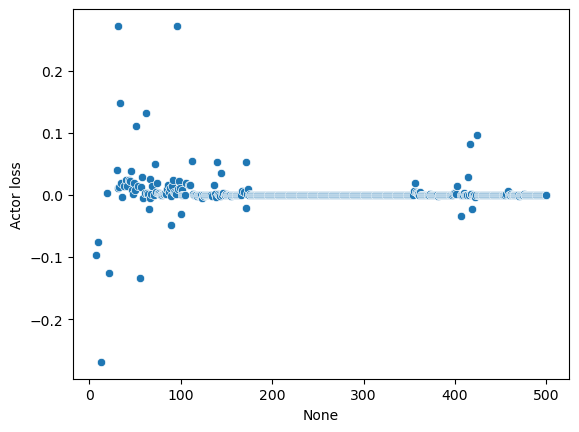

In [9]:
sns.scatterplot(data, x=data.index, y='Actor loss')

<Axes: xlabel='None', ylabel='Mean episodic reward'>

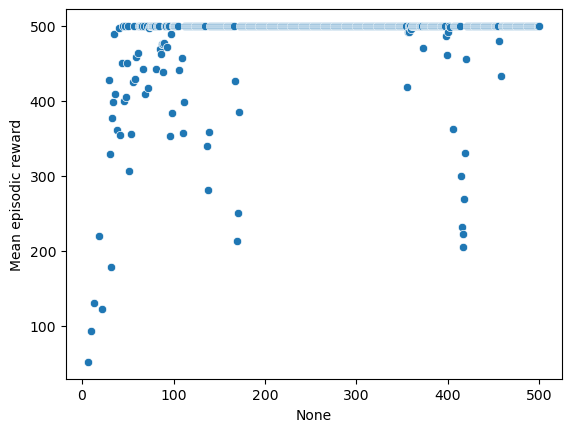

In [10]:
sns.scatterplot(data, x=data.index, y='Mean episodic reward')

<Axes: xlabel='None', ylabel='Mean episodic reward'>

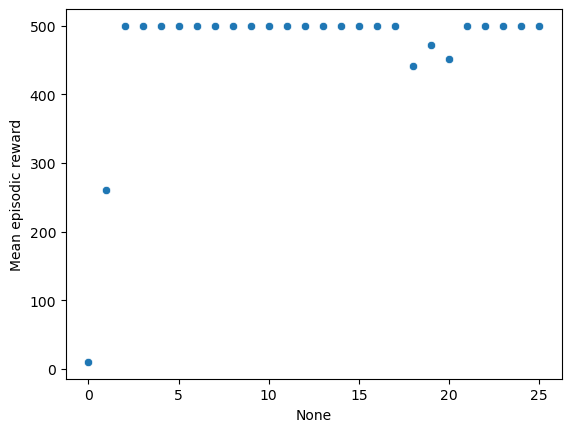

In [11]:
data2 = pd.read_csv(filenames[1])

sns.scatterplot(data2, x=data2.index, y='Mean episodic reward')

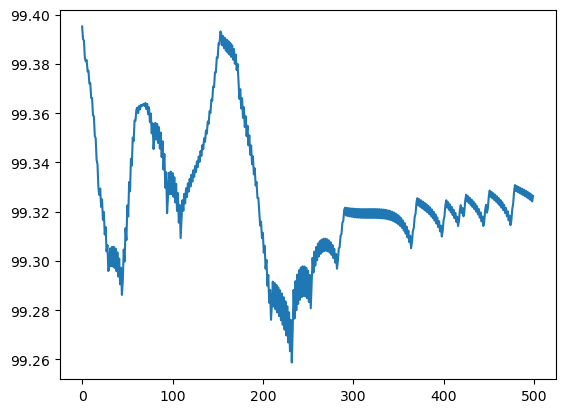

In [12]:
plt.plot(range(len(vs[7])), vs[7])